https://raw.githubusercontent.com/gabriel1200/shot_averages/refs/heads/main/201939.csv
       PLAYER_NAME  PLAYER_ID      shot_description  shot_type  shot_count  \
0    Stephen Curry     201939     Driving Hook Shot          2           1   
1    Stephen Curry     201939         Driving Layup          2          80   
2    Stephen Curry     201939    Fadeaway Jump Shot          2           7   
3    Stephen Curry     201939           Finger Roll          2          22   
4    Stephen Curry     201939    Floating Jump Shot          2          40   
..             ...        ...                   ...        ...         ...   
289  Stephen Curry     201939        Standard Layup          2          23   
290  Stephen Curry     201939   Step Back Jump Shot          2          10   
291  Stephen Curry     201939   Step Back Jump Shot          3          61   
292  Stephen Curry     201939  Turnaround Jump Shot          2           3   
293  Stephen Curry     201939  Turnaround Jump Shot    

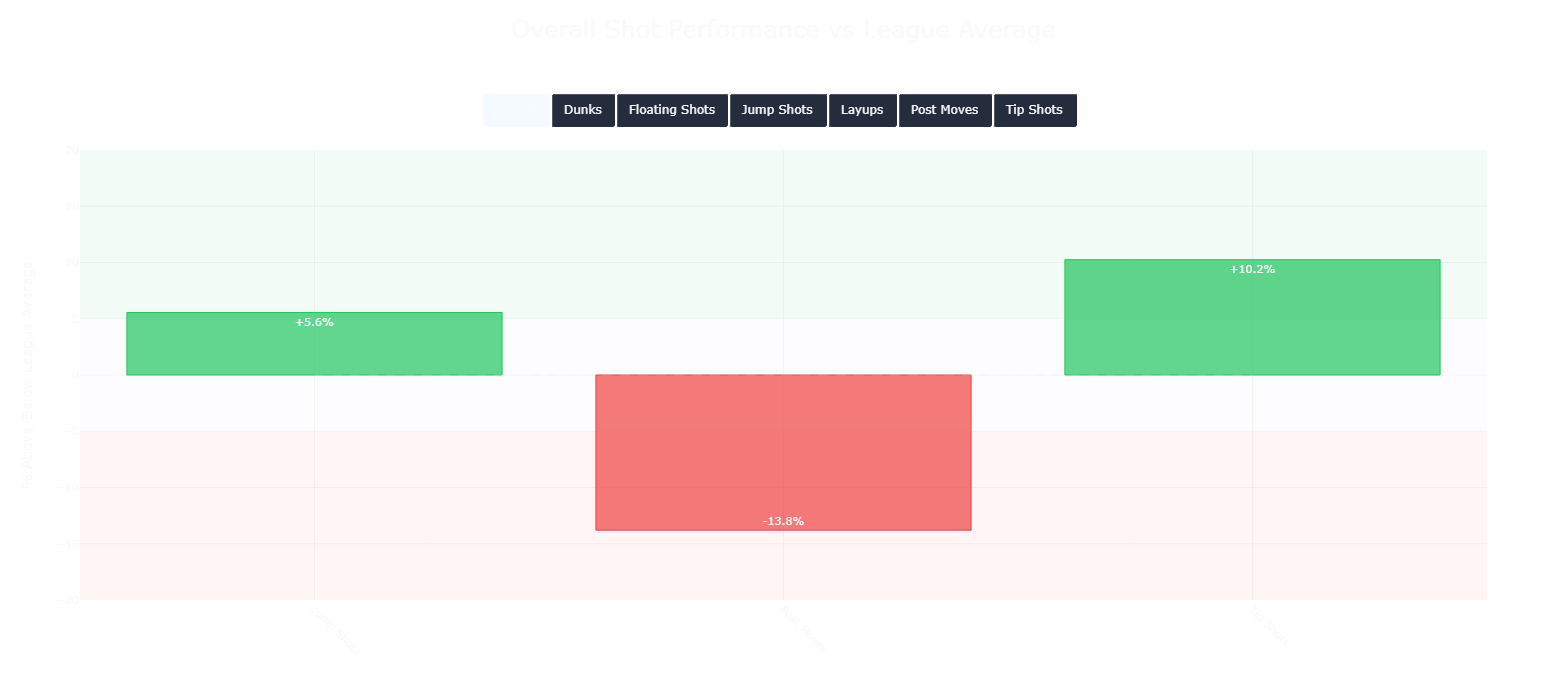

In [29]:
import plotly.graph_objects as go
import pandas as pd
# Example data structure (replace with actual data passed in your Flask app)
selected_player='201939'


selected_year=2009
def shot_performance(selected_player, selected_year, shot_range=2):
    avg_df = pd.read_csv('https://raw.githubusercontent.com/gabriel1200/shot_data/refs/heads/master/shot_types.csv')
    player_df = pd.read_csv(f'https://raw.githubusercontent.com/gabriel1200/shot_averages/refs/heads/main/{selected_player}.csv')
    print(f'https://raw.githubusercontent.com/gabriel1200/shot_averages/refs/heads/main/{selected_player}.csv')
    print(player_df)
    print(player_df['shot_makes'].sum())    
    print(player_df['shot_count'].sum())    
    player_df['shot_type'] = player_df.apply(
        lambda row: '3PT Field Goal' if row['shot_group'] == '3PT' else '2PT Field Goal', axis=1
    )
    avg_df['shot_type'] = avg_df.apply(
        lambda row: '3PT Field Goal' if row['shot_group'] == '3PT' else '2PT Field Goal', axis=1
    )
    value_map={'2PT Field Goal':1,'3PT Field Goal':1.5}
    avg_df['shot_value']=avg_df['shot_type'].map(value_map)
    player_df['shot_value']=player_df['shot_type'].map(value_map)


    avg_df['efg%']=(avg_df['shot_makes']*avg_df['shot_value'])/avg_df['shot_count']
    player_df['efg%']=(player_df['shot_makes']*player_df['shot_value'])/player_df['shot_count']

    shot_groups = sorted(player_df['shot_group'].unique())

    print(player_df['shot_group'].unique())
    print(avg_df['shot_group'].unique())
    
    def get_overall_data():
        shot_type = '3PT Field Goal' if shot_range == 3 else '2PT Field Goal'
        filtered_df = player_df[player_df['shot_type'] == shot_type]
        avg_df_filtered = avg_df[avg_df['shot_type'] == shot_type]
        
        overall_data = []
        total_shots = filtered_df['shot_count'].sum()
        
        for group in shot_groups:
            group_shots = filtered_df[filtered_df['shot_group'] == group]
            if not group_shots.empty:
                attempts = group_shots['shot_count'].sum()
                makes = group_shots['shot_makes'].sum()
                player_pct = (makes / attempts) * 100 if attempts > 0 else 0
                
                # Calculate weighted league average for the category
                group_league_pct = 0
                total_group_attempts = 0
                
                for shot_desc in group_shots['shot_description'].unique():
                    shot_attempts = group_shots[group_shots['shot_description'] == shot_desc]['shot_count'].sum()
                    league_data = avg_df_filtered[
                        (avg_df_filtered['shot_description'] == shot_desc) & 
                        (avg_df_filtered['year'] == int(selected_year))
                    ]
                    if not league_data.empty:
                        group_league_pct += shot_attempts * league_data['efg%'].iloc[0]
                        total_group_attempts += shot_attempts
                
                if total_group_attempts > 0:
                    group_league_pct = (group_league_pct / total_group_attempts) * 100
                    
                    overall_data.append({
                        'shot_description': group.replace('_', ' ').title(),
                        'player_pct': player_pct,
                        'league_pct': group_league_pct,
                        'difference': player_pct - group_league_pct,
                        'attempts': attempts,
                        'makes': makes,
                        'volume_pct': (attempts / total_shots) * 100
                    })
        
        return sorted(overall_data, key=lambda x: x['attempts'], reverse=True)
    
    def get_shot_data(selected_group):
        shot_type = '3PT Field Goal' if shot_range == 3 else '2PT Field Goal'
        group_df = player_df[
            (player_df['shot_group'] == selected_group) & 
            (player_df['shot_type'] == shot_type)
        ]
        avg_df_filtered = avg_df[avg_df['shot_type'] == shot_type]
        
        shot_data = []
        for shot_desc in group_df['shot_description'].unique():
            player_shots = group_df[group_df['shot_description'] == shot_desc]
            league_avg = avg_df_filtered[
                (avg_df_filtered['shot_description'] == shot_desc) & 
                (avg_df_filtered['year'] == int(selected_year))
            ]
            
            if not player_shots.empty and not league_avg.empty:
                attempts = player_shots['shot_count'].sum()
                makes = player_shots['shot_makes'].sum()
                player_pct = (makes / attempts) * 100
                league_pct = league_avg['efg%'].iloc[0] * 100
                
                shot_data.append({
                    'shot_description': shot_desc,
                    'player_pct': player_pct,
                    'league_pct': league_pct,
                    'difference': player_pct - league_pct,
                    'attempts': attempts,
                    'makes': makes,
                    'volume_pct': attempts / group_df['shot_count'].sum() * 100
                })
        
        return sorted(shot_data, key=lambda x: x['attempts'], reverse=True)
    
    # Create figure
    fig = go.Figure()
    
    # Color scheme
    colors = {
        'positive': 'rgba(34, 197, 94, 0.7)',
        'positive_border': 'rgba(34, 197, 94, 1)',
        'negative': 'rgba(239, 68, 68, 0.7)',
        'negative_border': 'rgba(239, 68, 68, 1)',
        'reference': 'rgba(226, 232, 240, 0.3)',
        'text': '#F8FAFC',
        'background': 'rgba(15, 23, 42, 0.9)'
    }
    
    # Add overall data first
    overall_data = get_overall_data()
    print(overall_data)
    
    # Add overall bars
    fig.add_trace(
        go.Bar(
            name="Overall Performance",
            x=[d['shot_description'] for d in overall_data],
            y=[d['difference'] for d in overall_data],
            marker=dict(
                color=[colors['positive'] if d['difference'] >= 0 else colors['negative']
                      for d in overall_data],
                line=dict(
                    color=[colors['positive_border'] if d['difference'] >= 0 
                          else colors['negative_border'] for d in overall_data],
                    width=1
                )
            ),
            text=[f"{d['difference']:+.1f}%" if abs(d['difference']) >= 2 else ""
                  for d in overall_data],
            textposition='auto',
            textfont=dict(size=11, color=colors['text']),
            hovertemplate=(
                "<b>%{x}</b><br>" +
                "Difference: %{y:+.1f}%<br>" +
                "Player: %{customdata[0]:.1f}%<br>" +
                "League: %{customdata[1]:.1f}%<br>" +
                "Shot Volume: %{customdata[2]:.0f}%<br>" +
                "Makes/Attempts: %{customdata[3]}/%{customdata[4]}<br>" +
                "<extra></extra>"
            ),
            customdata=[[
                d['player_pct'],
                d['league_pct'],
                d['volume_pct'],
                d['makes'],
                d['attempts']
            ] for d in overall_data],
            visible=True
        )
    )
    
    # Add overall reference line
    fig.add_trace(
        go.Scatter(
            x=[d['shot_description'] for d in overall_data],
            y=[0] * len(overall_data),
            mode='lines',
            name='League Average',
            line=dict(
                color=colors['reference'],
                width=1,
                dash='dash'
            ),
            hoverinfo='skip',
            visible=True
        )
    )
    
    # Create data for each shot group
    for group in shot_groups:
        shot_data = get_shot_data(group)
        all_data=True
        
        if all_data:
            # Add difference bars
            fig.add_trace(
                go.Bar(
                    name="vs. League Average",
                    x=[d['shot_description'] for d in shot_data],
                    y=[d['difference'] for d in shot_data],
                    marker=dict(
                        color=[colors['positive'] if d['difference'] >= 0 else colors['negative']
                              for d in shot_data],
                        line=dict(
                            color=[colors['positive_border'] if d['difference'] >= 0 
                                  else colors['negative_border'] for d in shot_data],
                            width=1
                        )
                    ),
                    text=[f"{d['difference']:+.1f}%" if abs(d['difference']) >= 2 else ""
                          for d in shot_data],
                    textposition='auto',
                    textfont=dict(size=11, color=colors['text']),
                    hovertemplate=(
                        "<b>%{x}</b><br>" +
                        "Difference: %{y:+.1f}%<br>" +
                        "Player: %{customdata[0]:.1f}%<br>" +
                        "League: %{customdata[1]:.1f}%<br>" +
                        "Shot Volume: %{customdata[2]:.0f}%<br>" +
                        "Makes/Attempts: %{customdata[3]}/%{customdata[4]}<br>" +
                        "<extra></extra>"
                    ),
                    customdata=[[
                        d['player_pct'],
                        d['league_pct'],
                        d['volume_pct'],
                        d['makes'],
                        d['attempts']
                    ] for d in shot_data],
                    visible=False
                )
            )
            
            # Add reference line
            fig.add_trace(
                go.Scatter(
                    x=[d['shot_description'] for d in shot_data],
                    y=[0] * len(shot_data),
                    mode='lines',
                    name='League Average',
                    line=dict(
                        color=colors['reference'],
                        width=1,
                        dash='dash'
                    ),
                    hoverinfo='skip',
                    visible=False
                )
            )
    
    # Create buttons including Overall
    buttons = [dict(
        label="Overall",
        method="update",
        args=[
            {"visible": [True, True] + [False] * (len(fig.data) - 2)},
            {"title": "Overall Shot Performance vs League Average"}
        ]
    )]
    
    for idx, group in enumerate(shot_groups):
        visibility = [True] * (len(fig.data))
        group_index = (idx + 1) * 2  # +1 because overall takes up first two traces
        visibility[group_index] = True
        visibility[group_index + 1] = True
        
        buttons.append(
            dict(
                label=group.replace('_', ' ').title(),
                method="update",
                args=[
                    {"visible": visibility},
                    {"title": f"Shot Performance vs League Average - {group.replace('_', ' ').title()}"}
                ]
            )
        )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text="Overall Shot Performance vs League Average",
            font=dict(size=24, color=colors['text']),
            y=0.97,
            x=0.5,
            xanchor='center'
        ),
        showlegend=False,
        xaxis=dict(
            tickangle=45,
            tickfont=dict(size=11, color=colors['text']),
            gridcolor="rgba(148, 163, 184, 0.1)"
        ),
        yaxis=dict(
            title=dict(
                text="% Above/Below League Average",
                font=dict(size=14, color=colors['text'])
            ),
            tickfont=dict(size=11, color=colors['text']),
            gridcolor="rgba(148, 163, 184, 0.1)",
            zeroline=False,
            range=[-20, 20]
        ),
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                x=0.5,
                y=1.15,
                xanchor='center',
                yanchor='top',
                showactive=True,
                buttons=buttons,
                font=dict(color=colors['text'], size=12),
                bgcolor=colors['background'],
                bordercolor='rgba(255, 255, 255, 0.2)',
                #activecolor='rgba(59, 130, 246, 0.7)',
                pad={"r": 10, "t": 10},
            )
        ],
        width=1200,
        height=700,
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        margin=dict(t=150, b=100, l=80, r=80)
    )
    
    # Add performance bands
    fig.add_hrect(y0=5, y1=20, fillcolor="rgba(34, 197, 94, 0.05)", layer="below", line_width=0)
    fig.add_hrect(y0=-5, y1=5, fillcolor="rgba(226, 232, 240, 0.05)", layer="below", line_width=0)
    fig.add_hrect(y0=-20, y1=-5, fillcolor="rgba(239, 68, 68, 0.05)", layer="below", line_width=0)
    
    return fig
    # Render the figure
fig = shot_performance(selected_player,selected_year)
fig.show()

In [2]:
avg_df[avg_df.shot_description.isna()]

NameError: name 'avg_df' is not defined